# Homework set 4

Please **submit this Jupyter notebook through Canvas** no later than **Monday December 9, 9:00**. **Submit the notebook file with your answers (as .ipynb file) and a pdf printout. The pdf version can be used by the teachers to provide feedback. On canvas there are hints about creating a nice pdf version.**

Before you hand in, please make sure the notebook runs, by running "Restart kernel and run all cells..." from the Kernel menu.

Homework is in **groups of two**, and you are expected to hand in original work. Work that is copied from another group will not be accepted.

# Exercise 0
Write down the names + student ID of the people in your group.

Run the following cell to import NumPy, Matplotlib. If anything else is needed you can import this yourself.

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# Exercise 1
N.B.1. you are to implement the methods yourself.

N.B.2. Tentative distribution of points is 2+1+2+2+2 points (plus 1 point makes 10).

Given a function $f$, let $T(f,a,b,m)$ denote the composite trapezoid rule with $m$ subintervals over the interval $[a,b]$. 

## (a)
Approximate the integral of $x^{-3}$ over $[a,b] = [ \frac{1}{10}, 100 ]$ by the composite trapezoid rule $T(f,a,b,m)$ for $m = 2^k$. Plot the absolute approximation error for different values of $k$. Find the smallest $k$ such that the exact error is less than $\epsilon = 10^{-3}$. Explain the slow convergence.

In [141]:
### Original Function (x^-3)
def f(x):
    global func_evals
    func_evals += 1
    return x ** -3

def exact_integral(a, b):
    return -0.5 * (b ** (-2) - a ** (-2))

### Limits of Integration
a, b = 1/10, 100

def trapezoid_rule(f, a, b, m):
    # Create vector of xs and compute all f(x)
    x = np.linspace(a, b, m + 1)
    y = np.array([f(xi) for xi in x]) 

    # Define segment
    h = (b - a) / m

    return h * (0.5 * y[0] + 0.5 * y[-1] + np.sum(y[1:-1]))


In [153]:
func_evals = 0
m = 2**18
approximation = trapezoid_rule(f, a, b, m)
exact_value = exact_integral(a, b)

print(f"Approximation: {approximation}")
print(f"Exact Value: {exact_value}")
print(f"Function Evaluations: {func_evals}")

Approximation: 50.000313068891145
Exact Value: 49.99994999999999
Function Evaluations: 262145


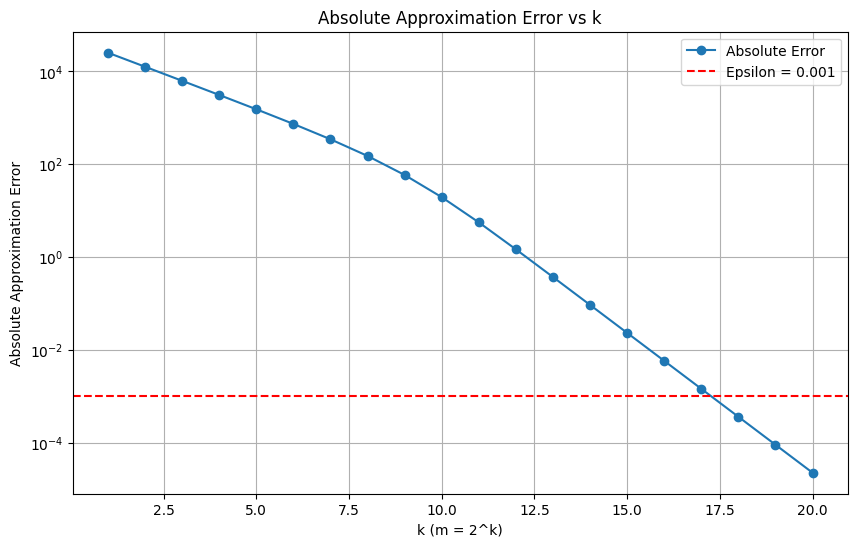

Smallest k such that error < epsilon: 18


In [142]:
epsilon = 1e-3
ks = np.arange(1, 21)
errors = []
ms = 2**ks

for m in ms:
    approx = trapezoid_rule(f, a, b, m)
    exact = exact_integral(a, b)  # Use the exact integral function
    errors.append(abs(approx - exact))

if np.any(np.array(errors) < epsilon):
    k_min = ks[np.where(np.array(errors) < epsilon)[0][0]]
else:
    k_min = None

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ks, errors, marker='o', label="Absolute Error")
plt.axhline(epsilon, color='r', linestyle='--', label=f"Epsilon = {epsilon}")
plt.xlabel("k (m = 2^k)")
plt.ylabel("Absolute Approximation Error")
plt.yscale('log')
plt.title("Absolute Approximation Error vs k")
plt.legend()
plt.grid()
plt.show()

print(f"Smallest k such that error < epsilon: {k_min}")

## (b)

To improve the convergence rate of the above problem, we may use an adaptive strategy, as discussed in the book and the lecture. Consider the following formulas for approximate integration
$$I_1(f,a,b) = T(f,a,b,1)$$
$$I_2(f,a,b) = T(f,a,b,2).$$
Show, based on the precise error estimates for the trapezoid rule from the book/lecture that the error in $I_2$ can be estimated by a formula of the form 
$$E_2 = C (I_1 - I_2)$$
and determine the constant $C$ (if you can't find $C$, you may take $C = 0.5$).

In [194]:
# Sanity Check
I_exact = exact_integral(a, b)
I1 = trapezoid_rule(f, a, b, 1)
I2 = trapezoid_rule(f, a, b, 2)
E2 = I2 - I_exact 
# Ik kom er niet, heb jij een idee?

The composite trapezoid rule $T(f, a, b, m)$ has an error of the form
$$
E_i = - \frac{(b-a)^3}{12m^2}f''(\epsilon_i) 
$$
where $\epsilon_i \in [a, b]$. Thus, for $E_1$ and $E_2$

$$
E_1 = - \frac{(b-a)^3}{12}f''(\epsilon_1) \\
E_2 = - \frac{(b-a)^3}{48}f''(\epsilon_2)
$$
Plug 

## (c)
An adaptive strategy for computing the integral on an interval $[a,b]$ now is: Compute $I_2$ and $E_2$, and accept $I_2$ as an approximation when the estimated error $E_2$ is less or equal than a desired tolerance $\epsilon$.  Otherwise, apply the procedure to 
$\int_a^{\frac{b+a}{2}} f(x) \, dx$ and $\int_{\frac{b+a}{2}}^b f(x) \, dx$ with tolerances $\frac{\epsilon}{2}$.

Write a recursive python routine that implements the adaptive strategy.

Then apply this routine to the function $x^{-3}$ with $a, b, \epsilon$ as before. What is the exact error in the obtained approximation? 

In [234]:
def adapt_quad(f, a, b, epsilon):
    global func_evals
    # Trapezoidal approximations
    I1 = trapezoid_rule(f, a, b, 1)  
    I2 = trapezoid_rule(f, a, b, 2) 

    # Error estimation
    C = 1 / 2  
    E2 = C * abs(I1 - I2)

    # Check if the error is within the desired tolerance
    if E2 <= epsilon:
        return I2, E2  # Accept the finer approximation
    else:
        # Recursively apply adaptive quadrature on left and right intervals
        mid = (a + b) / 2
        left_result, _ = adapt_quad(f, a, mid, epsilon / 2)
        right_result, _ = adapt_quad(f, mid, b, epsilon / 2)

        # Combine results from both halves
        return left_result + right_result, E2



In [255]:

def trapezoid_rule_with_error(f, a, b, epsilon):
    global func_evals
    I_curr = trapezoid_rule(f, a, b, 1)  # Initial approximation
    error = float('inf')  # Initial error, set high to enter the loop
    m = 2
    
    true_value = exact_integral(a,b)

    while error >= epsilon:
        func_evals = 0 
        m *= 2
        I_curr = trapezoid_rule(f, a, b, m)
        error = abs(true_value - I_curr)

    return func_evals, I_curr, m 

        


In [256]:
# Fixed-step trapezoidal rule
epsilon = 1e-3
func_evals = 0
evals_trapezoidal, result_trapezoid, intervals = trapezoid_rule_with_error(f, a, b, epsilon)
print(f"Trapezoid Result: {result_trapezoid}")
print(f"Function Evaluations (Trapezoid) (should be {intervals+1}): {evals_trapezoidal}")

# Adaptive quadrature
func_evals = 0
result_adaptive, error_quad = adapt_quad(f, a, b, epsilon)
print(f"Adaptive Quadrature Result: {result_adaptive}")
print(f"Function Evaluations (Adaptive): {func_evals}")

Trapezoid Result: 50.000313068891145
Function Evaluations (Trapezoid) (should be 262145): 262145
Adaptive Quadrature Result: 50.000138791821996
Function Evaluations (Adaptive): 59495


## (d)

Modify the code of (c) so that the number of function evaluations is counted. Optimize your implementation such that no unnecessary function evaluations are performed.

Compare the number of function evaluations used in the adaptive strategy of (c) with the result of (a). 
(*Hint*: To count the number of function evaluations, you may use a global variable.)


## (e)
In the course of executing the recursive procedure, some subintervals are refined (split into two subintervals) while others aren't as a result of the choices made by the algorithm. It turns out that the choices made by this algorithm are not always optimal. Other algorithms, that decide in a different way which subinterval needs to be refined, may be more efficient in the sense that they require less function evaluations (while using the same formulas for the approximate integral and the approximate error associated with a subinterval).

Can you explain why this is the case? Devise an alternative, non-recursive algorithm that addresses this issue and should to lead a more efficient integral computation. Describe your approach and algorithm in about 5 to 10 sentences (bullet points).
